In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd /content/drive/MyDrive/proj/models_data
# %ls 

/content/drive/MyDrive/proj/models_data


In [ ]:
from enum import Enum
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim, tensor
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# general params

In [ ]:
PATH_DATASET = './datasets'
NUM_CLASSES = 10
BATCH_SIZE = 20
NUM_TRAIN = 1000
NUM_VALID = 100
NUM_TEST = 100
EPOCHS = 4
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
ENSEMBLE_SIZE = 10
PATH_MODELS_SAVE = r'/content/drive/MyDrive/proj/models_data'

##Usefull func

In [ ]:
def get_cifar10():
    """
    get cifar10 train set and test set

    Returns:
        cifar10 train set and test set
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
    ])

    # train mean = [0.49139968, 0.48215841, 0.44653091]
    # train std  = [0.24703223, 0.24348513, 0.26158784]

    dataset_train = torchvision.datasets.CIFAR10(PATH_DATASET, train=True, transform=transform, download=True)
    dataset_test = torchvision.datasets.CIFAR10(PATH_DATASET, train=False, transform=transform, download=True)
    return dataset_train, dataset_test

def get_loader(dataset, idx, shuffle=True):
    subset = torch.utils.data.Subset(dataset, idx)
    return torch.utils.data.DataLoader(subset, batch_size=BATCH_SIZE, shuffle=shuffle)

def get_model():
    model = models.resnet18(weights=None)  # ,pretrained=False
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    # model.load_state_dict(torch.load('ResNet18.pt'))
    model.to(DEVICE)

    # lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0001)

    return model, criterion, optimizer

##el2n

In [ ]:
def get_el2n_scores(y, ensemble_pred):
    """
    calculate mean on the L2 over ensemble of algorithms

    :param y: labels, shape: (data len)
    :param ensemble_pred: scores for every data example, shape: (ensemble size, data len, labels len)

    :return: el2n_scores: vector of scores how the example hard to learn for every data
             shape: (data len)
    """
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=ensemble_pred.shape[-1])
    return torch.mean(torch.linalg.norm(y_one_hot - ensemble_pred, ord=2, dim=2), dim=0)


def get_prune_idx(y, ensemble_pred, prune_size: float, keep_hardest: bool = True):
    return get_el2n_scores(y, ensemble_pred).argsort(descending=keep_hardest)[:int(prune_size * y.shape[0])]

##Global definations

In [ ]:
# check if CUDA is available
TRAIN_ON_GPU = torch.cuda.is_available()
DEVICE = 'cuda' if TRAIN_ON_GPU else 'cpu'

if not TRAIN_ON_GPU:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# torch.manual_seed(5)

CUDA is available!  Training on GPU ...


##train model functions

In [ ]:
class Mode(Enum):
    TRAIN = 0
    VALIDATE = 1
    TEST = 2


def train(model, train_loader, valid_loader, test_loader, criterion, optimizer, epochs: int, save_path='',
          verbose: bool = True):
    loss_train, loss_valid, loss_valid_min, acc_train, acc_valid = [], [], np.Inf, [], []
    scores_train, scores_valid, scores_test = None, None, None

    for epoch in range(epochs):
        scores_train, loss, acc = run_epoch(model, criterion, optimizer, train_loader, Mode.TRAIN)
        loss_train.append(loss), acc_train.append(acc)
        scores_valid, loss, acc_test = run_epoch(model, criterion, optimizer, valid_loader, Mode.VALIDATE)
        loss_valid.append(loss), acc_valid.append(acc)

        # print training/validation statistics
        if verbose:
            print(f'Epoch: {epoch} Training: Loss: {loss_train[-1]:.6f} Acc: {acc_train[-1]:.6f}  '
                  f'Validation Loss: {loss_valid[-1]:.6f} Acc: {acc_valid[-1]:.6f}')

        # save model if validation loss has decreased
        if save_path and loss_valid[-1] <= loss_valid_min:
            if verbose:
                print(f'Validation loss decreased ({loss_valid_min:.6f} --> {loss_valid[-1]:.6f}).  '
                      f'Saving model to {save_path}')
            torch.save(model.state_dict(), save_path)
            loss_valid_min = loss_valid[-1]

    scores_test, loss_test, acc_test = run_epoch(model, criterion, optimizer, test_loader, Mode.TEST)
    if verbose:
        print(f'Test Loss: {loss_test:.6f}')
        print(f'Accuracy: {acc_test}')

    return (scores_train, loss_train, acc_train), (scores_valid, loss_valid, acc_valid), \
           (scores_test, loss_test, acc_test)



def run_epoch(model, criterion, optimizer, loader, mode: Mode = Mode.TRAIN):
    model.train() if mode == Mode.TRAIN else model.eval()

    loss, loss_min, acc = .0, np.Inf, .0
    len_dataset = len(loader.dataset)
    scores = torch.empty((len(loader.dataset), NUM_CLASSES))

    for batch_idx, (X, y) in enumerate(loader):
        if TRAIN_ON_GPU:
            X, y = X.cuda(), y.cuda()
        if mode == Mode.TRAIN:
            optimizer.zero_grad()

        p = model(X)
        loss_batch = criterion(p, y)
        loss += loss_batch.item()

        if mode == Mode.TRAIN:
            loss_batch.backward()
            optimizer.step()
        else:
            scores[batch_idx * BATCH_SIZE:(batch_idx + 1) * BATCH_SIZE] = p.clone().detach()

        _, pred = torch.max(p, 1)
        acc += torch.sum(pred.eq(y))

    return scores, loss / len_dataset, acc / len_dataset

In [ ]:
# get data
data_train, data_test = get_cifar10()

loader_train = get_loader(data_train, np.arange(NUM_TRAIN))
loader_valid = get_loader(data_train, np.arange(NUM_TRAIN, NUM_VALID + NUM_TRAIN))
loader_test = get_loader(data_test, np.arange(NUM_TEST))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


In [ ]:
ensemble = [get_model() for _ in range(ENSEMBLE_SIZE)]
prune_size = .5
ensemble_softmax = torch.empty((len(ensemble), NUM_TRAIN, NUM_CLASSES), device=DEVICE)
ensemble_pred = torch.empty((NUM_TRAIN, len(ensemble)), dtype=torch.bool, device=DEVICE)
ensemble_pred_sum = torch.empty((NUM_TRAIN,), dtype=torch.int8, device=DEVICE)
idx = np.arange(NUM_TRAIN)
# create loader with no shuffling
loader_prune = get_loader(data_train, idx, shuffle=False)
Y_train = tensor(data_train.targets, device=DEVICE)[idx]

for i, (model, criterion, optimizer) in enumerate(ensemble):
    print(f'------------   model {i}   -------------------')
    path = os.path.join(PATH_MODELS_SAVE, f'resnet18_{i}')
    (scores_train, loss_train, acc_train), (scores_valid, loss_valid, acc_valid), (
        scores_test, loss_test, acc_test) = \
        train(model, loader_train, loader_valid, loader_test, criterion, optimizer, 10, verbose=True, save_path=path)

    model.eval()
    for batch_idx, (X, y) in enumerate(loader_prune):
        if TRAIN_ON_GPU:
            X, y = X.cuda(), y.cuda()
        pred = model(X)
        idx = np.arange(batch_idx * BATCH_SIZE, (batch_idx + 1) * BATCH_SIZE)
        ensemble_softmax[i, idx] = F.softmax(pred, dim=1)
        ensemble_pred[idx, i] = (torch.max(pred, 1)[1].type(torch.int8) == y)

ensemble_pred_sum = torch.sum(ensemble_pred, dim=1)
el2n_scores = get_el2n_scores(Y_train, ensemble_softmax).detach().cpu().numpy()

# save data
torch.save(ensemble_pred_sum, os.path.join(PATH_MODELS_SAVE, 'ensemble_pred_sum.pt'))
torch.save(ensemble_pred, os.path.join(PATH_MODELS_SAVE, 'ensemble_pred.pt'))
torch.save(ensemble_softmax, os.path.join(PATH_MODELS_SAVE, 'ensemble_softmax.pt'))
torch.save(el2n_scores, os.path.join(PATH_MODELS_SAVE, 'el2n_scores.pt'))

------------   model 0   -------------------
Epoch: 0 Training: Loss: 0.120262 Acc: 0.111000  Validation Loss: 0.114686 Acc: 0.111000
Validation loss decreased (inf --> 0.114686).  Saving model to /content/drive/MyDrive/proj/models_data/resnet18_0
Epoch: 1 Training: Loss: 0.108215 Acc: 0.205000  Validation Loss: 0.112075 Acc: 0.205000
Validation loss decreased (0.114686 --> 0.112075).  Saving model to /content/drive/MyDrive/proj/models_data/resnet18_0
Epoch: 2 Training: Loss: 0.099586 Acc: 0.288000  Validation Loss: 0.110155 Acc: 0.288000
Validation loss decreased (0.112075 --> 0.110155).  Saving model to /content/drive/MyDrive/proj/models_data/resnet18_0
Epoch: 3 Training: Loss: 0.092169 Acc: 0.359000  Validation Loss: 0.105844 Acc: 0.359000
Validation loss decreased (0.110155 --> 0.105844).  Saving model to /content/drive/MyDrive/proj/models_data/resnet18_0
Epoch: 4 Training: Loss: 0.084450 Acc: 0.440000  Validation Loss: 0.104429 Acc: 0.440000
Validation loss decreased (0.105844 -->

# 

In [ ]:
# for each model: count how mach prediction was true
torch.sum(ensemble_pred, dim=0)

NameError: ignored

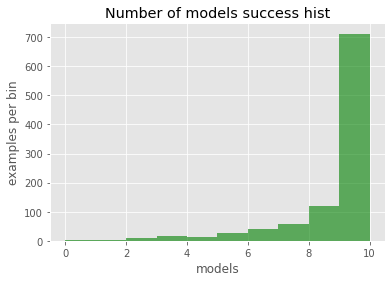

In [ ]:
plt.style.use('ggplot')
plt.hist(ensemble_pred_sum.cpu(), bins=len(ensemble), facecolor='g', alpha=0.6)
plt.xlabel('models')
plt.ylabel('examples per bin')
plt.title('Number of models success hist')
plt.show()

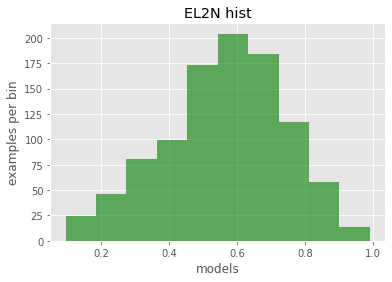

In [ ]:
plt.hist(el2n_scores, bins=len(data_train.classes), facecolor='g', alpha=0.6)
plt.xlabel('models')
plt.ylabel('examples per bin')
plt.title('EL2N hist')
plt.show()

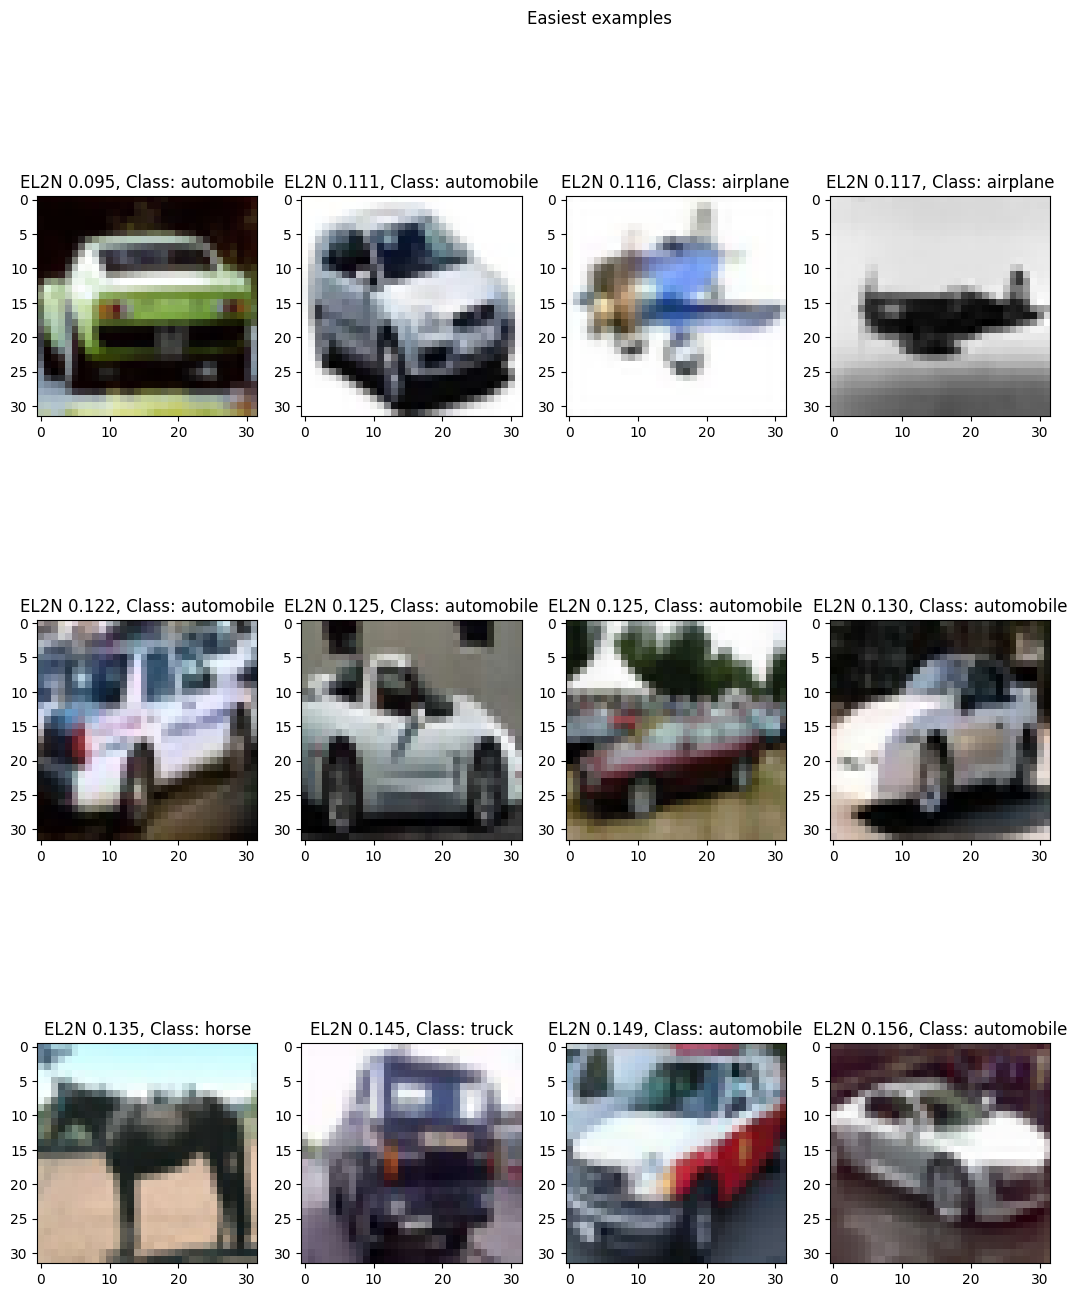

In [ ]:
# [easy,...,hard]
data_train_raw = torchvision.datasets.CIFAR10(PATH_DATASET, train=True)
el2n_scores_idx = np.argsort(el2n_scores)
plt.style.use('default')
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
fig.suptitle('Easiest examples')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
for ax, i in zip(axes.reshape(-1), el2n_scores_idx[:12]):
    ax.imshow(data_train_raw[i][0])
    ax.set_title(f'EL2N {el2n_scores[i]:.3f}, Class: {data_train_raw.classes[data_train_raw[i][1]]}')
plt.show()

## Hardest examples

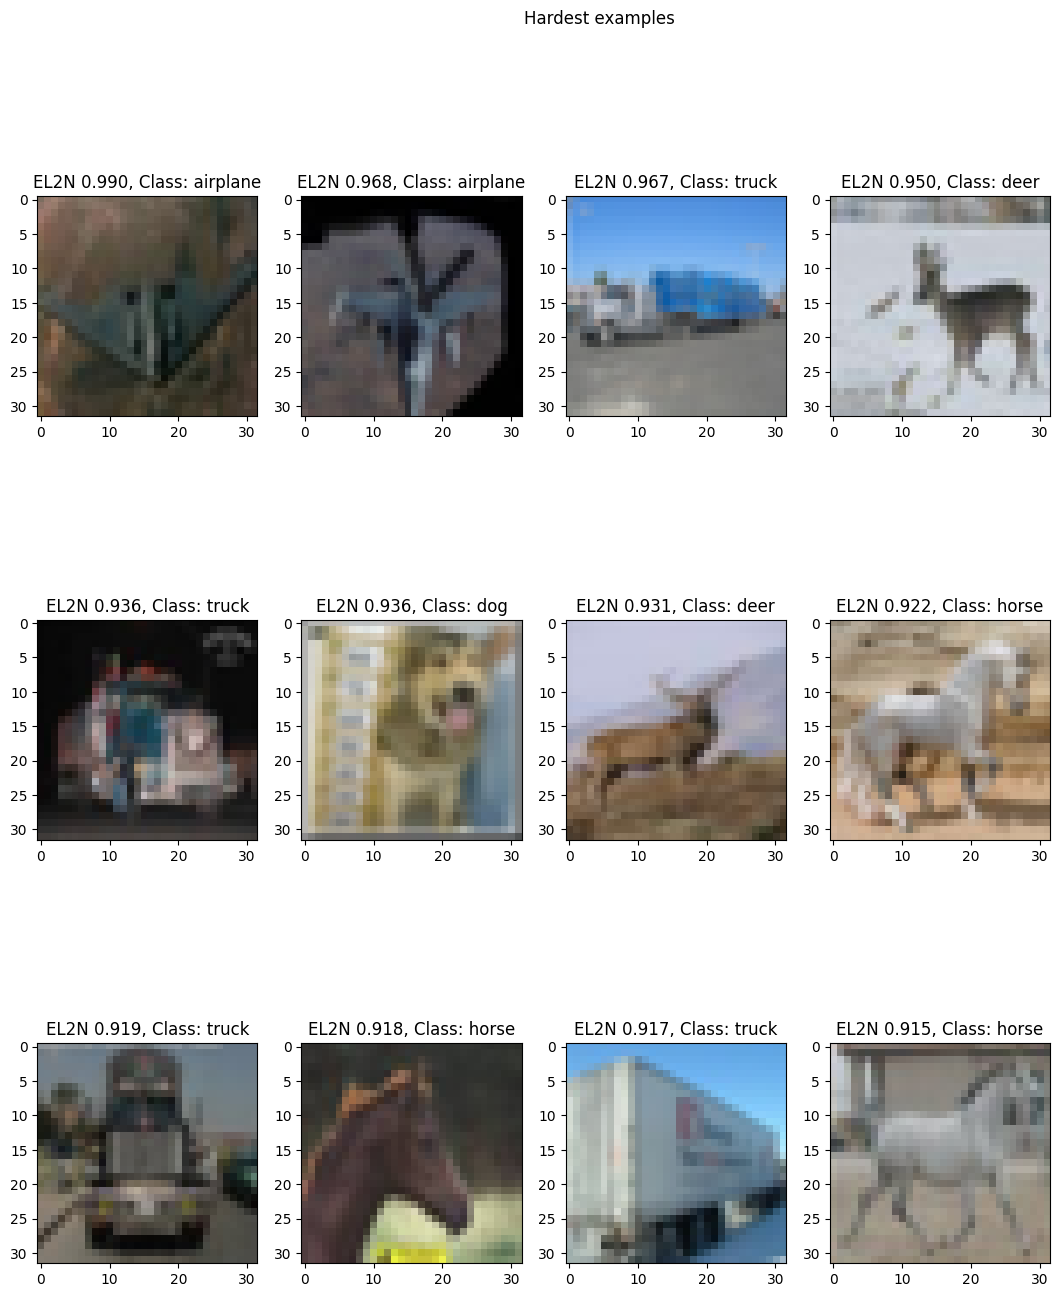

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
fig.suptitle('Hardest examples')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
for ax, i in zip(axes.reshape(-1), el2n_scores_idx[-12:][::-1]):
    ax.imshow(data_train_raw[i][0])
    ax.set_title(f'EL2N {el2n_scores[i]:.3f}, Class: {data_train_raw.classes[data_train_raw[i][1]]}')
plt.show()

In [ ]:
M = ensemble_pred.clone().detach().cpu()

In [ ]:
idx_to_keep = get_prune_idx(Y_train, ensemble_softmax, prune_size)

loader_train = get_loader(data_train, idx_to_keep, True)
model_prune, criterion_prune, optimizer_prune = get_model()
model_simple, criterion_simple, optimizer_simple = get_model()

In [ ]:
# train model with prune
(scores_train_p, loss_train_p, acc_train_p), (
    scores_valid_p, loss_valid_p, acc_valid_p), (
    scores_test_p, loss_test_p, acc_test_p) = \
    train(model_prune, loader_prune, loader_valid, loader_test, criterion_prune, optimizer_prune, EPOCHS,
          verbose=True, save_path=os.path.join(PATH_MODELS_SAVE, 'resnet18_prune'))
# torch.save(model_simple.state_dict(), './model_simple.pt')

In [ ]:
# train model without prune
(scores_train, loss_train, acc_train), (scores_valid, loss_valid, acc_valid), (
    scores_test, loss_test, acc_test) = \
    train(model_simple, loader_train, loader_valid, loader_test, criterion_simple, optimizer_simple, EPOCHS,
          verbose=True, save_path=os.path.join(PATH_MODELS_SAVE, 'resnet18_no_prune'))
# torch.save(model_prune.state_dict(), './model_prune.pt')
# load: model.load_state_dict(torch.load(PATH))

In [ ]:
fig, (ax_train_loss, ax_valid_loss) = plt.subplots(1, 2)
ax_train_loss.plot(np.arange(EPOCHS), loss_train_p, label='prune')
ax_train_loss.plot(np.arange(EPOCHS), loss_train, label='simple')
ax_train_loss.set_title('train loss')
ax_valid_loss.plot(np.arange(EPOCHS), loss_valid_p, label='prune')
ax_valid_loss.plot(np.arange(EPOCHS), loss_valid, label='simple')
ax_valid_loss.set_title('valid loss')

for ax in (ax_train_loss, ax_valid_loss):
    ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.grid(True)
ax.legend(loc='upper right')

plt.show()